In [7]:
from CNN_modules import *
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
import time

# Create Training and testing data set

In [14]:
nk=10
num=
Y=[]
choosen_t=[]
choosen_theta=[]


norb=get_model().get_num_orbitals()

#input wavefunctions
X=np.zeros((num,nk,nk,norb*norb))

for i,j in tqdm(enumerate(np.linspace(0,1,num))):

    #create random variable for input 
    theta=np.random.uniform(low=0, high=2*np.pi)
    k=np.random.uniform(low=0, high=1)
    t=np.random.uniform(low=-.2, high=.2)
    # solve the model for wavefunctions
    my_model=get_model(delta=t,theta=theta)
    evec=get_wav(my_model,nk)
    Y.append(get_chern(my_model,k_origin=k))

    # reshape wve functions for our Neural network input
    X[i]=reshape_evec(evec,phase=False)
    
    # get the input parameters of the training subspace
    choosen_t.append(t)
    choosen_theta.append(theta)

500it [00:24, 20.78it/s]


## Create Training and testing subsets

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2)
encoder,y_train = process_y(y_train)
_,y_test = process_y(y_test)

# Get CNN Model

In [16]:
model=get_NNmodel(X_train)
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 9, 9, 10)          170       
_________________________________________________________________
dropout_3 (Dropout)          (None, 9, 9, 10)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 5)           205       
_________________________________________________________________
dropout_4 (Dropout)          (None, 8, 8, 5)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 963       
Total params: 1,338
Trainable params: 1,338
Non-trainable params: 0
____________________________________________________

### Train the model

In [17]:
start = time.time()

history=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200,verbose=0)

print('Processing time:',(time.time()- start)/60)

Processing time: 0.15928879578908284


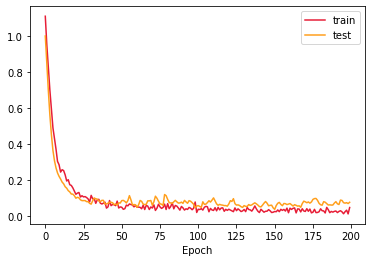

In [18]:
plt.plot(history.history['loss'], label='train',c="#e71d36")
plt.plot(history.history['val_loss'], label='test',c="#ff9f1c")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Plot the phase diagram and the prediction

In [19]:
num=50 # mesh to plot
norb=get_model().get_num_orbitals() 
val=[]
val_actual=[]
theta=np.linspace(0,np.pi*2,num) # theta
t=np.linspace(-2,2,num) # nearest neibghot interaction
for i in tqdm(t, position=0):
    for j in theta:
        #get the model and actual data
        my_model=get_model(delta=i,theta=j)
        evec=get_wav(my_model,nk)
        val_actual.append(get_chern(my_model))

        # test the NN's prediction
        test=reshape_evec(evec,phase=False)
        pred=model.predict([[test]])
        O=np.array([-1,0,1])
        val.append(np.sum(np.multiply(O,pred)))
        

100%|██████████| 50/50 [02:02<00:00,  2.45s/it]


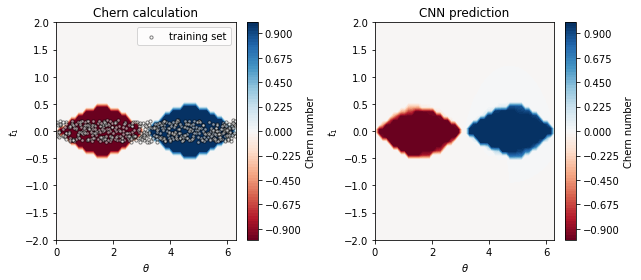

In [23]:
fig,ax=plt.subplots(1,2,figsize=(9,4))
r=ax[1].contourf(theta,t,np.array(val).reshape(num,num),90,cmap="RdBu",vmin=-1,vmax=1)
plt.colorbar(r,ax=ax[1],label="Chern number")


r=ax[0].contourf(theta,t,np.array(val_actual).reshape(num,num),90,cmap="RdBu",vmin=-1,vmax=1)
plt.colorbar(r,ax=ax[0],label="Chern number")
ax[0].scatter(choosen_theta,choosen_t,s=10,alpha=.5,c="w",label="training set",edgecolors="k")
ax[0].legend()

ax[0].set_title("Chern calculation")
ax[1].set_title("CNN prediction")
for i in ax:
    i.set_xlabel("$\\theta$")
    i.set_ylabel("$t_1$")
plt.tight_layout()
plt.savefig("figs/CNN_model_real_imag.png",dpi=300)
plt.show()